In [12]:
import airfoils as af
import matplotlib.pyplot as plt
import numpy as np
import potential as pot
from wing import Wing

# Airfoil

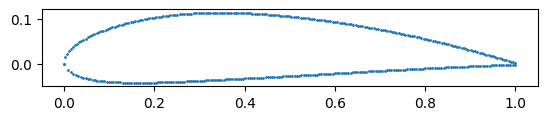

In [13]:
airfoil = af.Airfoil.NACA4("4415", n_points=200)
af_xs, af_ys = airfoil.all_points
plt.scatter(af_xs, af_ys, 1)
plt.axis('scaled')

alpha0 = -4 * np.pi / 180

# Slanted Wake Horseshoe

We are trying to model figure (a)
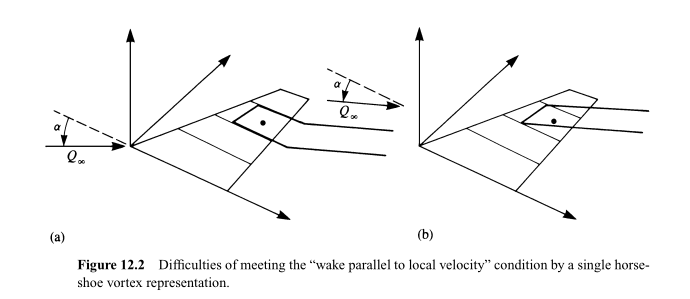

# Wing Geometry

In [14]:
def linSpan(sp, Ni):
    return np.linspace(0, sp, Ni)

def uniformChord(Ni, ch=1):
    return ch * np.ones(Ni)

In [15]:
N = 100
M = 3
wg = Wing(
    airfoil=airfoil,
    isSymmetric=True,
    span=6,
    alpha=2,
    beta=0,
    Ni=N,
    Nj=M,
    sweepOffset=0,
    dihAngle=0,
    chordFun=uniformChord,
    spanFun=linSpan
)
# %matplotlib qt
# wg.plotgrid()

## Wind

In [16]:
Umag = 20
dens = 1.225

## Solve

In [17]:
L_SL, D_SL, Gammas, w_ind = wg.solveWingHS(alpha0, Umag, dens, pot.hshoeSL2)
print(f"L:{L_SL}\t|\tD:{D_SL}")
print(f"CL:{2*L_SL/(dens*(Umag**2)*wg.wingArea)}\t|\tCD_ind:{2*D_SL/(dens*(Umag**2)*wg.wingArea)}")

L:702.6415899366481	|	D:18.373870929312993
CL:0.4779874761473796	|	CD_ind:0.012499231924702715


/tmp/ipykernel_587209/3667275855.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


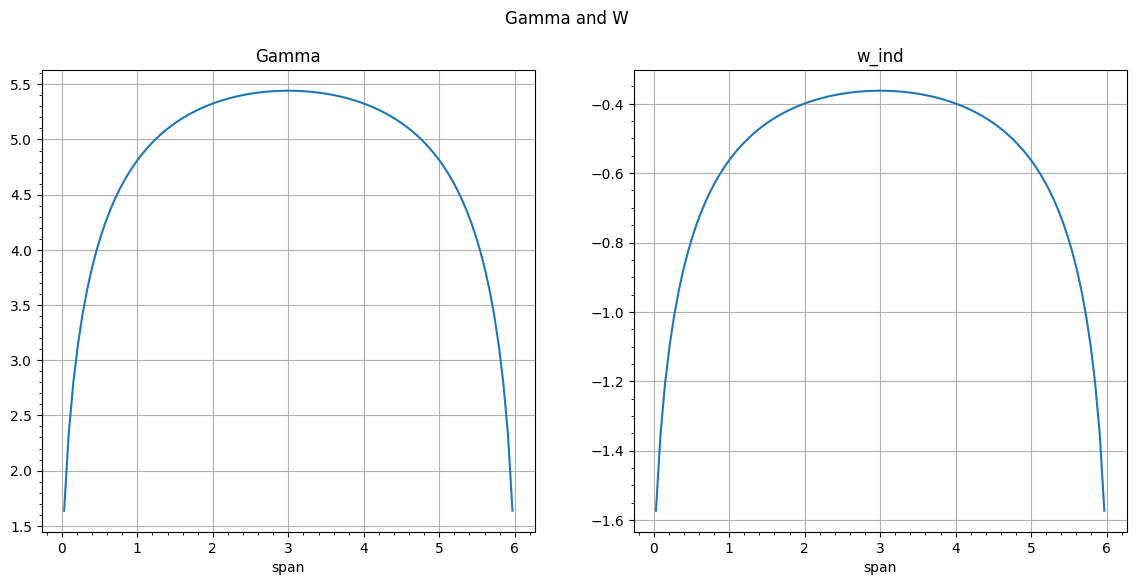

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Gamma and W')

ax1.plot((wg.Dspan[1:] + wg.Dspan[:-1])/2, Gammas)
ax1.set_xlabel("span")
ax1.set_title("Gamma")
ax1.minorticks_on()
ax1.grid()

ax2.plot((wg.Dspan[1:] + wg.Dspan[:-1])/2, w_ind)#(w_ind/Umag) * 180 / np.pi)
ax2.set_xlabel("span")
ax2.set_title("w_ind")
ax2.minorticks_on()
ax2.grid()
fig.show()


In [19]:
L_pan = np.zeros((wg.N-1))
D_pan = np.zeros((wg.N-1))
for i in np.arange(0, wg.N-1):
    L_pan[i] = dens * Umag * Gammas[i] * \
        (wg.grid[i+1, 0, 1] - wg.grid[i, 0, 1])
    D_pan[i] = - dens * w_ind[i] * Gammas[i] * \
        (wg.grid[i+1, 0, 1] - wg.grid[i, 0, 1])

L = np.sum(L_pan)
D = np.sum(D_pan)


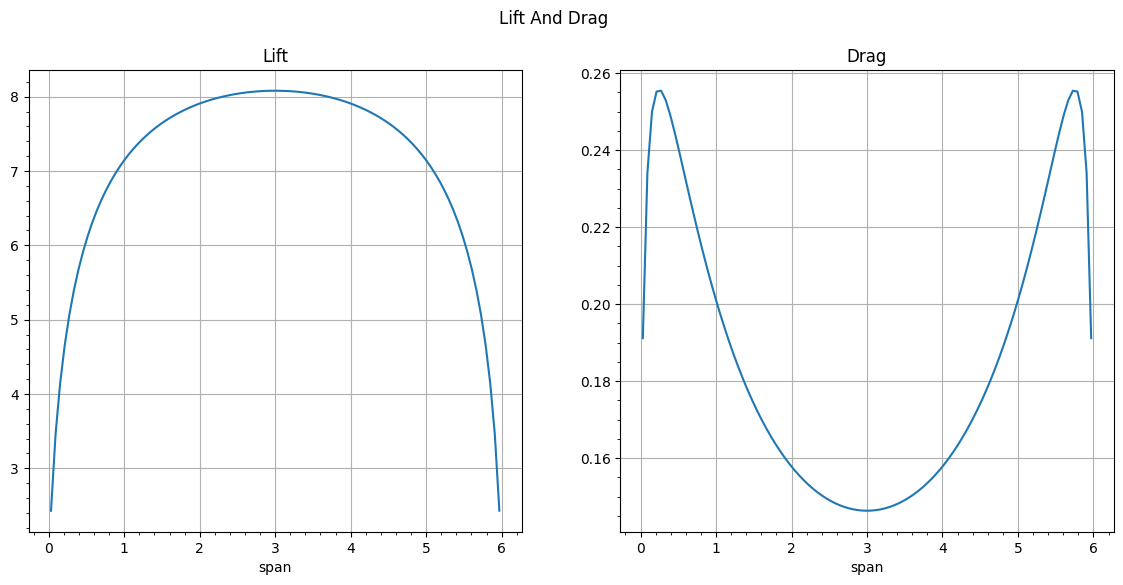

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Lift And Drag')

ax1.plot((wg.Dspan[1:] + wg.Dspan[:-1])/2, L_pan)
ax1.set_xlabel("span")
ax1.set_title("Lift")
ax1.minorticks_on()
ax1.grid()

ax2.plot((wg.Dspan[1:] + wg.Dspan[:-1])/2, D_pan)
ax2.set_xlabel("span")
ax2.set_title("Drag")
ax2.minorticks_on()
ax2.grid()


# Grid Dependence

In [21]:
# LvsDisc = []
# DvsDisc = []
# GammavsDisc = []
# WindvsDisc = []
# Νss = np.linspace(5, 400, 100)
# for ni in Νss:
#     wg = Wing(
#         airfoil=airfoil,
#         isSymmetric=True,
#         span=6,
#         alpha=2,
#         beta=0,
#         Ni=int(ni),
#         Nj=M,
#         sweepOffset=0,
#         dihAngle=0,
#         chordFun=uniformChord,
#         spanFun=linSpan
#     )
#     L, D, Gamma, w = wg.solveWingHS(alpha0, Umag, dens, pot.hshoeSL2)
#     LvsDisc.append(L)
#     DvsDisc.append(D)
#     GammavsDisc.append(Gamma)
#     WindvsDisc.append(w)
# LvsDisc = np.array(LvsDisc)
# DvsDisc = np.array(DvsDisc)
# GammavsDisc = np.array(GammavsDisc)
# WindvsDisc = np.array(WindvsDisc)


In [22]:
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 6))
# fig.suptitle('Grid Independence')

# ax1.plot(Νss, 2 * LvsDisc)
# ax1.set_xlabel("N")
# ax1.set_title("Lift")
# ax1.minorticks_on()
# ax1.grid()

# ax2.plot(Νss, 2*DvsDisc)
# ax2.set_xlabel("N")
# ax2.set_title("Drag")
# ax2.minorticks_on()
# ax2.grid()

# ax3.plot(Νss, LvsDisc / DvsDisc)
# ax3.set_xlabel("N")
# ax3.set_title("L/D")
# ax3.minorticks_on()
# ax3.grid()

# fig.show()
